In [2]:
import pandas as pd
import numpy as np
import csv
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import logging
import math
from lmfit import minimize, fit_report, Parameters
from aim2_population_model_spatial_aff_parallel import get_mod_spike
from model_constants import (MC_GROUPS, LifConstants)
from popul_model import pop_model
from aim2_population_model_spatial_aff_parallel import Afferent, SimulationConfig, Simulation

In [3]:
#Global Variables
# lmpars_init_dict = {}
# lmpars = Parameters()
# lmpars.add('tau1', value=8, vary=False)
# lmpars.add('tau2', value=200, vary=False)
# lmpars.add('tau3', value=1744.6, vary=False)
# lmpars.add('tau4', value=np.inf, vary=False)
# lmpars.add('k1', value=.74, vary=False, min=0) #a constant
# #try and double b  
# lmpars.add('k2', value=5.5, vary=False, min=0) #b constant
# #fix these try k3-.5 k4.5 and then .75, .25
# lmpars.add('k3', value=.01, vary=False, min=0) #c constant
# lmpars.add('k4', value=.099, vary=False, min=0)
# lmpars_init_dict['t3f12v3final'] = lmpars
lmpars_init_dict = {}
lmpars = Parameters()
lmpars.add('tau1', value=8, vary=False)
lmpars.add('tau2', value=200, vary=False)
lmpars.add('tau3', value=1744.6, vary=False)
lmpars.add('tau4', value=np.inf, vary=False)
lmpars.add('k1', value=.74, vary=False, min=0) #a constant
lmpars.add('k2', value=2.75, vary=False, min=0) #b constant
lmpars.add('k3', value=.07, vary=False, min=0) #c constant
lmpars.add('k4', value=.0312, vary=False, min=0)
lmpars_init_dict['t3f12v3final'] = lmpars


In [4]:

def radial_stress_vf_model(afferent_type, vf_tip_size, scaling_factor = 1.0):
    """ Read in the Radial which has sample stress traces for every 2mm from a center point
    to calculate firing"""

    #regex pattern for exstracting the distance from the middle point
    distance_regex = r'\d\.\d{2}'

    #Reading in the radial stress file
    # radial_stress = pd.read_csv(f"data/vfspatial/{vf_tip_size}_radial_stress.csv")
    #Reading the new anika data in
    radial_stress = pd.read_csv(f"data/anika_new_data/{vf_tip_size}/{vf_tip_size}_radial_stress_corr.csv")
    radial_time = radial_stress['Time (ms)'].to_numpy()
    
    stress_data = {}
    iff_data = {}
    not_generated_radii = []

    # Inner loop to iterate through radial distances
    for col in radial_stress.columns[1:]:
        LifConstants.set_resolution(1)
        distance_from_center = float(re.findall(distance_regex, col)[0])

        # Initialize lists for each coordinate-distance pair
        afferent_type = []
        spikes = []
        mean_firing_frequency = []
        peak_firing_frequency = []
        first_spike_time = []
        last_spike_time = []

        # if radial_spatial_flag:
        #     radial_stress_vals = radial_stress[col]
        #     radial_stress_max = np.max(radial_stress_vals)
        #     distance_scaling_factor = spatial_stress_max / radial_stress_max
        #     radial_spatial_flag = False
        
        #where the scaling happens
        scaled_stress = radial_stress[col] *  scaling_factor

        stress_data[distance_from_center] = {
            "Time": radial_time,
            distance_from_center: scaled_stress.to_numpy()
        }

        lmpars = lmpars_init_dict['t3f12v3final']
        if afferent_type == "RA":
            lmpars['tau1'].value = 2.5
            lmpars['tau2'].value = 200
            lmpars['tau3'].value = 1
            lmpars['k1'].value = 35
            lmpars['k2'].value = 0
            lmpars['k3'].value = 0.0
            lmpars['k4'].value = 0

        groups = MC_GROUPS
        mod_spike_time, mod_fr_inst = get_mod_spike(lmpars, groups, stress_data[distance_from_center]["Time"], stress_data[distance_from_center][distance_from_center])

        if len(mod_spike_time) == 0 or len(mod_fr_inst) == 0:
            logging.warning(f"SPIKES COULD NOT BE GENERATED FOR {vf_tip_size}")
            not_generated_radii.append(distance_from_center)
            iff_data[distance_from_center] = None
            continue

        if len(mod_spike_time) != len(mod_fr_inst):
            if len(mod_fr_inst) > 1:
                mod_fr_inst_interp = np.interp(mod_spike_time, radial_time, mod_fr_inst)
            else:
                mod_fr_inst_interp = np.zeros_like(mod_spike_time)
        else:
            mod_fr_inst_interp = mod_fr_inst

        features, _ = pop_model(mod_spike_time, mod_fr_inst_interp)

        # Append single values to the lists
        afferent_type.append(afferent_type)
        spikes.append(len(mod_spike_time) if len(mod_spike_time) != 0 else None)
        mean_firing_frequency.append(features["Average Firing Rate"])
        peak_firing_frequency.append(np.max(mod_fr_inst_interp))
        first_spike_time.append(mod_spike_time[0] if len(mod_spike_time) != 0 else None)
        last_spike_time.append(mod_spike_time[-1])

        # Store each coordinate-distance dictionary within iff_data
        iff_data[distance_from_center] = {
            'afferent_type': afferent_type,
            'num_of_spikes': spikes[0],
            'mean_firing_frequency': mean_firing_frequency[0],
            'peak_firing_frequency': peak_firing_frequency[0],
            'first_spike_time': first_spike_time[0],
            'last_spike_time': last_spike_time[0]
        }

    return stress_data, iff_data, not_generated_radii

In [5]:
def plot_radius_scaling_factor(sf, radii):
    plt.plot(sf, radii)
    plt.xlabel("Scaling Factor")
    plt.ylabel("max Radii before firing stops")
    plt.title("Scaling Factor vs. Furthest firing distance from center of stimulus")
    plt.show()

In [5]:
scaling_factors = np.linspace(0,.5,50)

stresses = []
iffs = [] 
not_generated_radii = []

for sf in scaling_factors:
    stress, iff, ng_radii = radial_stress_vf_model("SA", 4.17, scaling_factor=sf)

    stresses.append(stress)
    iffs.append(iff)
    not_generated_radii.append(ng_radii)



In [6]:
not_generated_radius_max = [
    np.max(value) if len(value) != 0 and np.isscalar(np.max(value)) else 0 
    for value in not_generated_radii
]


print(not_generated_radius_max)
plot_radius_scaling_factor(scaling_factors, not_generated_radius_max)

NameError: name 'not_generated_radii' is not defined

In [23]:
stress_optimal, iff_optimal,_ = radial_stress_vf_model("SA", 4.56, scaling_factor=2.0)

In [11]:
def run_single_unit_model_combined_graph(afferent_type, stresses, scaling_factor=1.0):

    fig, axes = plt.subplots(5, 5, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.5, wspace=0.4)

    axes = axes.flatten()

    # finding comon limits
    common_x_min = 0
    common_x_max = max(data['Time'][-1] for data in stresses.values())
    common_y_min = min(min(data[distance]) for distance, data in stresses.items())
    common_y_max = max(max(data[distance]) for distance, data in stresses.items())

    legend = False
    # Iterate through each entry in the stress_data dictionary and each subplot
    for idx, (distance, data) in enumerate(stresses.items()):
        if idx >= 25:  # Only plot up to 25 entries for the 5x5 grid
            break
        
        time = data['Time']  # Extract the time array
        stress_values = scaling_factor * data[distance]  # Apply scaling factor


        lmpars = lmpars_init_dict['t3f12v3final']
        LifConstants.set_resolution(1)
        if afferent_type == "RA":
            lmpars['tau1'].value = 2.5
            lmpars['tau2'].value = 200
            lmpars['tau3'].value = 1
            lmpars['k1'].value = 35
            lmpars['k2'].value = 0
            lmpars['k3'].value = 0.0
            lmpars['k4'].value = 0

        groups = MC_GROUPS
        mod_spike_time, mod_fr_inst = get_mod_spike(lmpars, groups, time, stress_values)

        if len(mod_spike_time) == 0 or len(mod_fr_inst) == 0:
            logging.warning(f"SPIKES COULD NOT BE GENERATED for distance {distance}")
            continue

        if len(mod_spike_time) != len(mod_fr_inst):
            if len(mod_fr_inst) > 1:
                mod_fr_inst_interp = np.interp(mod_spike_time, time, mod_fr_inst)
            else:
                mod_fr_inst_interp = np.zeros_like(mod_spike_time)
        else:
            mod_fr_inst_interp = mod_fr_inst

        # plotting the data fro the current subplot
        axes[idx].plot(mod_spike_time, mod_fr_inst_interp * 1e3, label="Firing Rate (Hz)", marker='o', linestyle='none')
        axes[idx].plot(time, stress_values, label="Stress (kPa)", color="red")
        axes[idx].set_title(f'Distance {distance:.2f} mm')
        axes[idx].set_ylabel('Firing Rate (Hz) / Stress (kPa)')
        axes[idx].set_xlim(common_x_min, common_x_max)
        axes[idx].set_ylim(common_y_min, common_y_max)
        if not legend:
            axes[idx].legend()
            legend= True

    # Hide any unused subplots
    for ax in axes[len(stresses):]:
        ax.axis('off')

    lmpars = lmpars_init_dict['t3f12v3final']
    k2 = lmpars["k2"]
    k3 = lmpars["k3"]
    k4 = lmpars["k4"]
    print(k3.value)
    plt.savefig(f"vf_graphs/radial_plots/4.17_k2:{k2.value}_k3:{k3.value}_k4:{k4.value}_sf:{scaling_factor}.png")



0.07


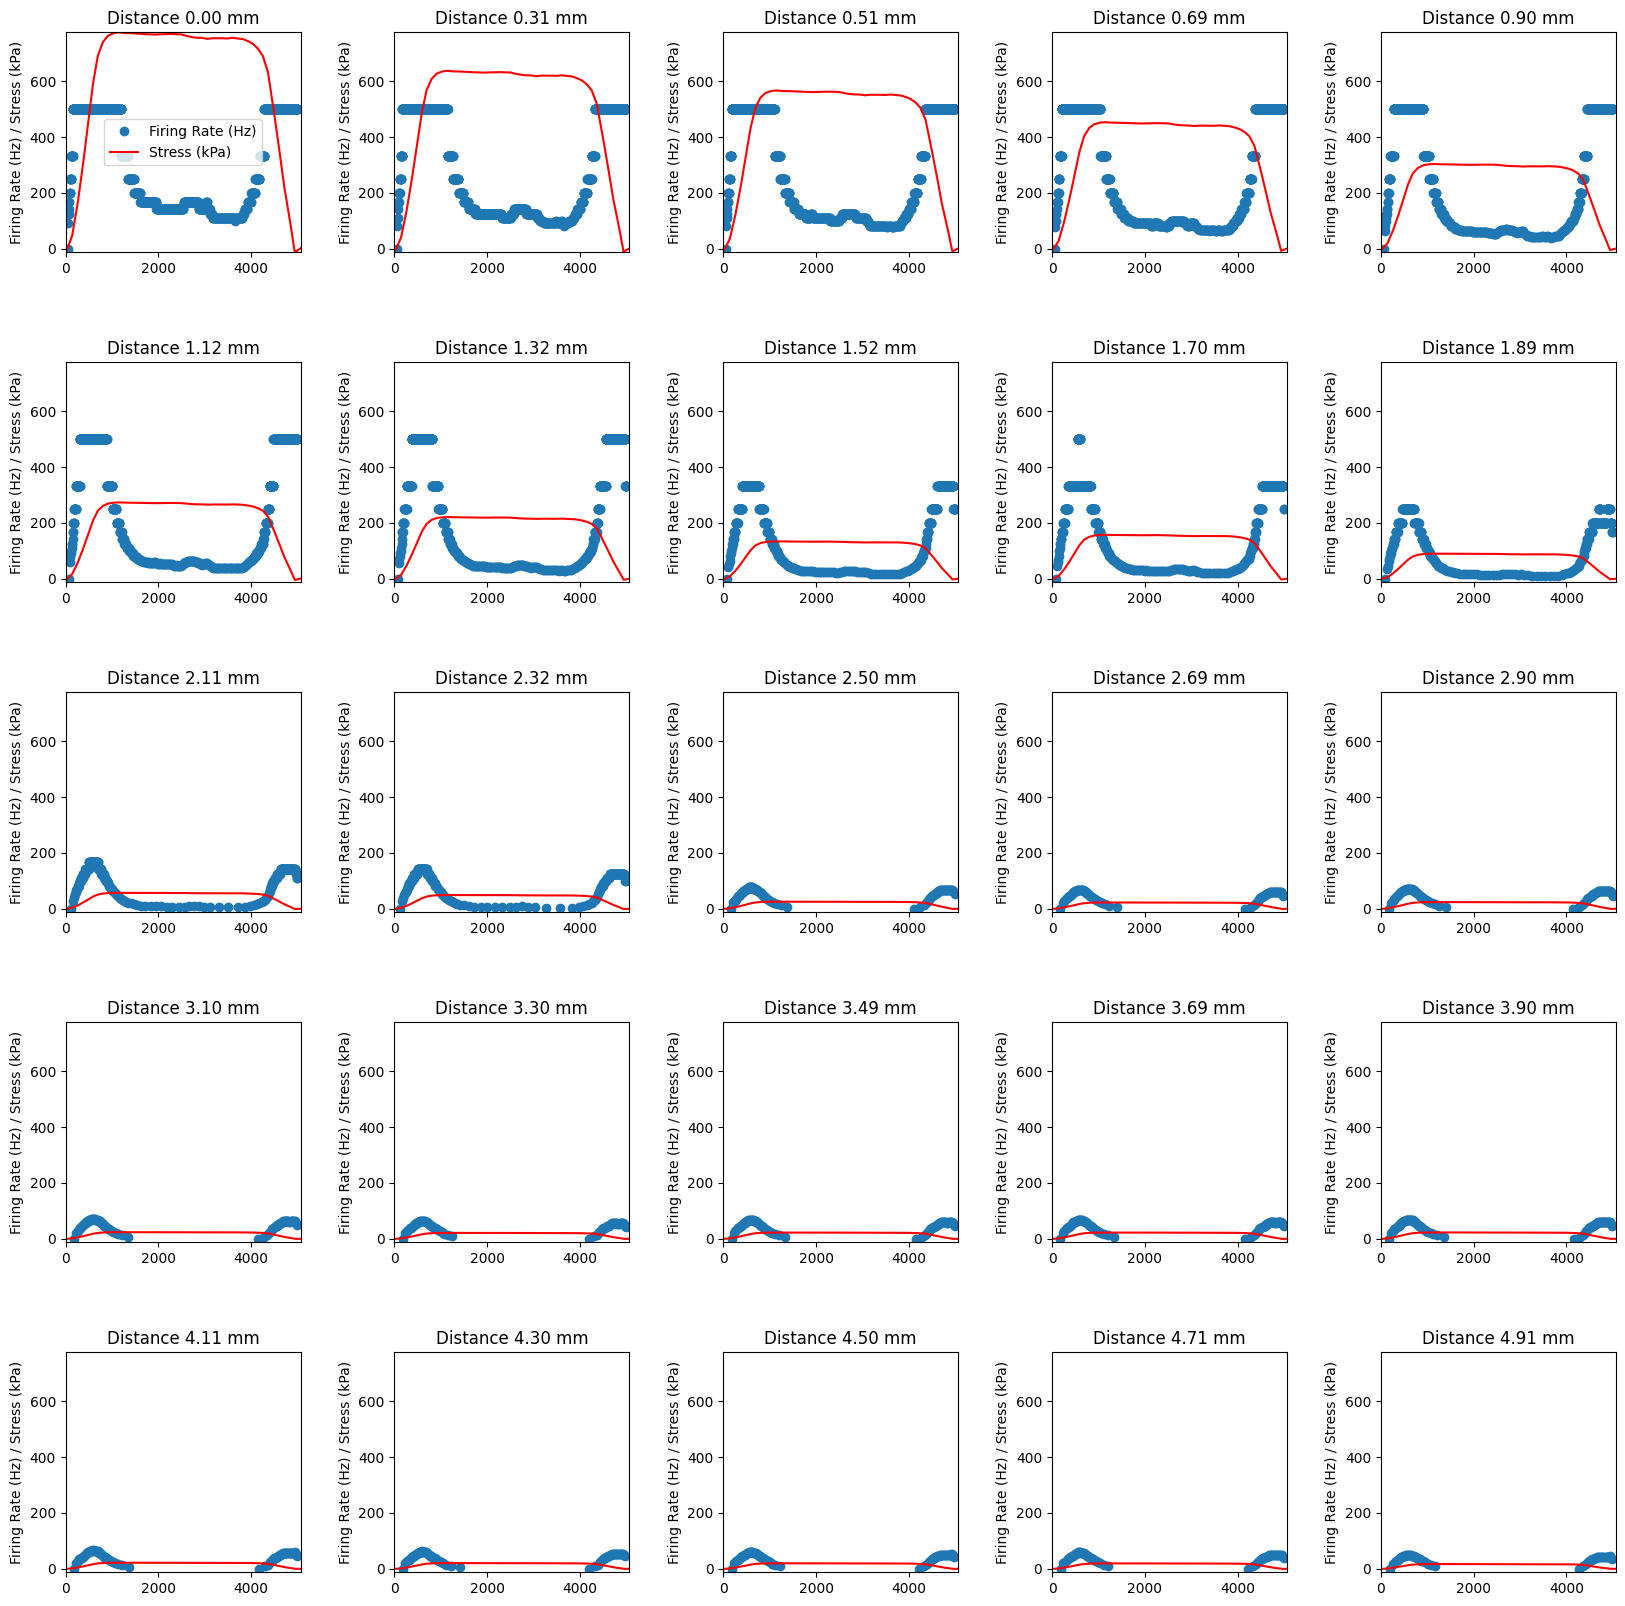

In [24]:
run_single_unit_model_combined_graph("SA",stress_optimal, scaling_factor = 1)